# 1. Imports

In [1]:
import sys, os, datetime, pickle, time
import string, pdb, tqdm
import random, keras, os.path, yaml
import pandas as pd
import numpy as np
#
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
#
from Img_preprocessor import Preprocessor
#
import tensorflow as tf
from tensorflow.keras import models
#
from timeit import default_timer as timer
from datetime import datetime, timedelta, date
from PIL import Image
# from IPython.display import Image
# %matplotlib inline

#
tf.autograph.set_verbosity(0)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# tf.get_logger().setLevel('ERROR')

[]


# 2. Preparing Data

In [2]:
# Obtener la ruta del directorio tres niveles arriba
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir))

# Cargar datasets desde el directorio tres niveles arriba
data_norm_path = os.path.join(parent_dir, 'Dataset/data_norm.pkl')

with open(data_norm_path, 'rb') as handle:
    GlblFrm = pickle.load(handle)
    dosD    = pickle.load(handle)
    coils   = pickle.load(handle)
    nclmaps = pickle.load(handle)


# 3. Building Sets

In [3]:
#  Selecting coils OK and NOK
lsids1 = coils.loc[coils['Label']==1,'SID'].tolist()
lsids2 = coils.loc[coils['Label']==2,'SID'].tolist()
#
# Select and extract 30 coil's sids for independent assessemnt
ass1 = random.sample(lsids1, 30)
ass2 = random.sample(lsids2, 30)
res1 = np.array(list(set(lsids1) - set(ass1)))
res2 = np.array(list(set(lsids2) - set(ass2)))
#
# The remaining are organized for building the model
random.shuffle(res1)
random.shuffle(res2)
train1, validate1, test1 = np.split(res1,[int(.7*len(res1)), int(.9*len(res1))])
train2, validate2, test2 = np.split(res2,[int(.7*len(res2)), int(.9*len(res2))])
#
# Building the full sets
train = train1.tolist() + train2.tolist()
valid = validate1.tolist() + validate2.tolist()
test  = test1.tolist()  + test2.tolist()
ass   = ass1   + ass2
#

In [4]:
def featureMap(id, nlcmaps):
    arr1 = nclmaps[id][1234]['nzne'].to_numpy()
    arr2 = nclmaps[id][1243]['nzne'].to_numpy()
    arr  = np.concatenate((arr1, arr2), axis=1)
    return(arr)
#
def prep_dataset(setd,nlcmaps):
    setd_f = []
    setd_l = []
    for i in setd:
        arrimg = featureMap(i, nclmaps)
        lbl = coils.loc[coils['SID']==i,'Label'].values[0]
        setd_f.append(arrimg)
        if lbl == 1:
            setd_l.append([1.,0.])
        if lbl == 2:
            setd_l.append([0.,1.])
    setd_f = np.array(setd_f)
    setd_l = np.array(setd_l)
    return([setd_f,setd_l])
#
def factory_rep(arr,step=0):
    # arr image havind 264 rows and 18 (9 face A+9 face B) columns of normalized data 
    # mirror per face over x axis
    # channels 0-3 => 5-8 and 5-8 => 0-3
    permut1 = list(range(8,4,-1))+[4] + list(range(3,-1,-1))+ list(range(17,13,-1))+[13]+list(range(12,8,-1))
    idx = np.empty_like(permut1)
    idx[permut1] = np.arange(len(permut1))
    arr1 = arr[:,idx]
    permut2 = list(range(263,131,-1))+ list(range(131,-1,-1))
    idx = np.empty_like(permut2)
    idx[permut2] = np.arange(len(permut2))    
    arr2 = arr[idx,:]
    arr3 = arr1[idx,:]
    res  = [arr, arr1, arr2, arr3]
    if step > 0:
        newa = arr
        end = arr.shape[0]-step
        for i in range(arr.shape[0] // step):
            permut = list(range(arr.shape[0]-step,arr.shape[0]))+list(range(0,end))
            idx = np.empty_like(permut)
            idx[permut] = np.arange(len(permut))
            newb= newa[idx,:]
            res.append(newb)
            newa= newb
    res = np.array(res)
    return(res)
#

def prep_dataset_aug(setd,nlcmaps,tlab=-1):
    setd_f = []
    setd_l = []
    for i in setd:
        arrimg = featureMap(i, nclmaps)
        lbl = coils.loc[coils['SID']==i,'Label'].values[0]
        if lbl == tlab: # if lower class => higher augmentation
            res = factory_rep(arrimg,step=8)
        else:
            res = factory_rep(arrimg)
        for j in range(res.shape[0]):
            setd_f.append(res[j,:,:])
            if lbl == 1:
                setd_l.append([1.,0.])
            if lbl == 2:
                setd_l.append([0.,1.])
    setd_f = np.array(setd_f)
    setd_l = np.array(setd_l)
    return([setd_f,setd_l])

In [5]:
goal = 'C:/Users/alexm/OneDrive/Escritorio/UNIVERSIDAD/TFG/ALVAREZ_CASTRO_Alejandro/ALVAREZ_CASTRO_Alejandro/ZN_1D_imgs/'
# for i in train + valid + test:
train_f, train_l = prep_dataset_aug(train,nclmaps,2)
np.savez(goal+'train.npz', features=train_f, labels=train_l)
#
valid_f, valid_l = prep_dataset(valid,nclmaps)
np.savez(goal+'validation.npz', features=valid_f, labels=valid_l)
#
test_f, test_l = prep_dataset(test,nclmaps)
np.savez(goal+'test.npz', features=test_f, labels=test_l)
#
ass_f, ass_l = prep_dataset(ass,nclmaps)
np.savez(goal+'assess.npz', features=ass_f, labels=ass_l)
#

# 4. Preprocess Images

In [6]:
# We have 4293 images of 264x18 pixels on the train set

# npzfile = np.load(goal+'train.npz')
# print(npzfile['features'].shape)
# print(npzfile['labels'].shape)

In [7]:
# Ruta donde se encuentran los archivos npz
goal_preprocessed = 'C:/Users/alexm/OneDrive/Escritorio/UNIVERSIDAD/TFG/ALVAREZ_CASTRO_Alejandro/ALVAREZ_CASTRO_Alejandro/repo/DQ_ACA_2024/B)/data/'
# Directorio donde se guardaron los labels del conjunto de datos "assess"
labels_dir_assess = 'C:/Users/alexm/OneDrive/Escritorio/UNIVERSIDAD/TFG/ALVAREZ_CASTRO_Alejandro/ALVAREZ_CASTRO_Alejandro/repo/DQ_ACA_2024/B)/data/assess/labels'
# Directorio donde se guardaron las imágenes PNG del conjunto de datos "assess"
features_dir_assess = 'C:/Users/alexm/OneDrive/Escritorio/UNIVERSIDAD/TFG/ALVAREZ_CASTRO_Alejandro/ALVAREZ_CASTRO_Alejandro/repo/DQ_ACA_2024/B)/data/assess/features'

# Cargar los archivos npz
npzfile_train = np.load(goal + 'train.npz')
npzfile_validation = np.load(goal + 'validation.npz')
npzfile_test = np.load(goal + 'test.npz')
npzfile_assess = np.load(goal + 'assess.npz')

In [8]:
# Crear instancia de Preprocessor y llamar al método preprocess
preprocessor = Preprocessor(npzfile_train, npzfile_validation, npzfile_test, npzfile_assess)


preprocessor.preprocess(goal_preprocessed)

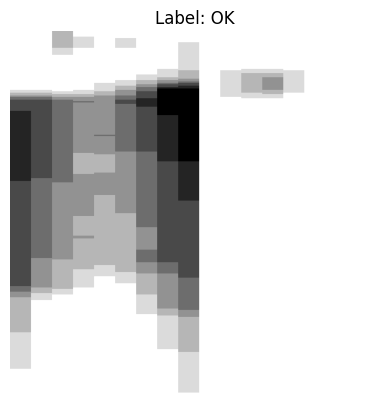

In [9]:
preprocessor.visualize_first_image_assess(features_dir_assess, labels_dir_assess)

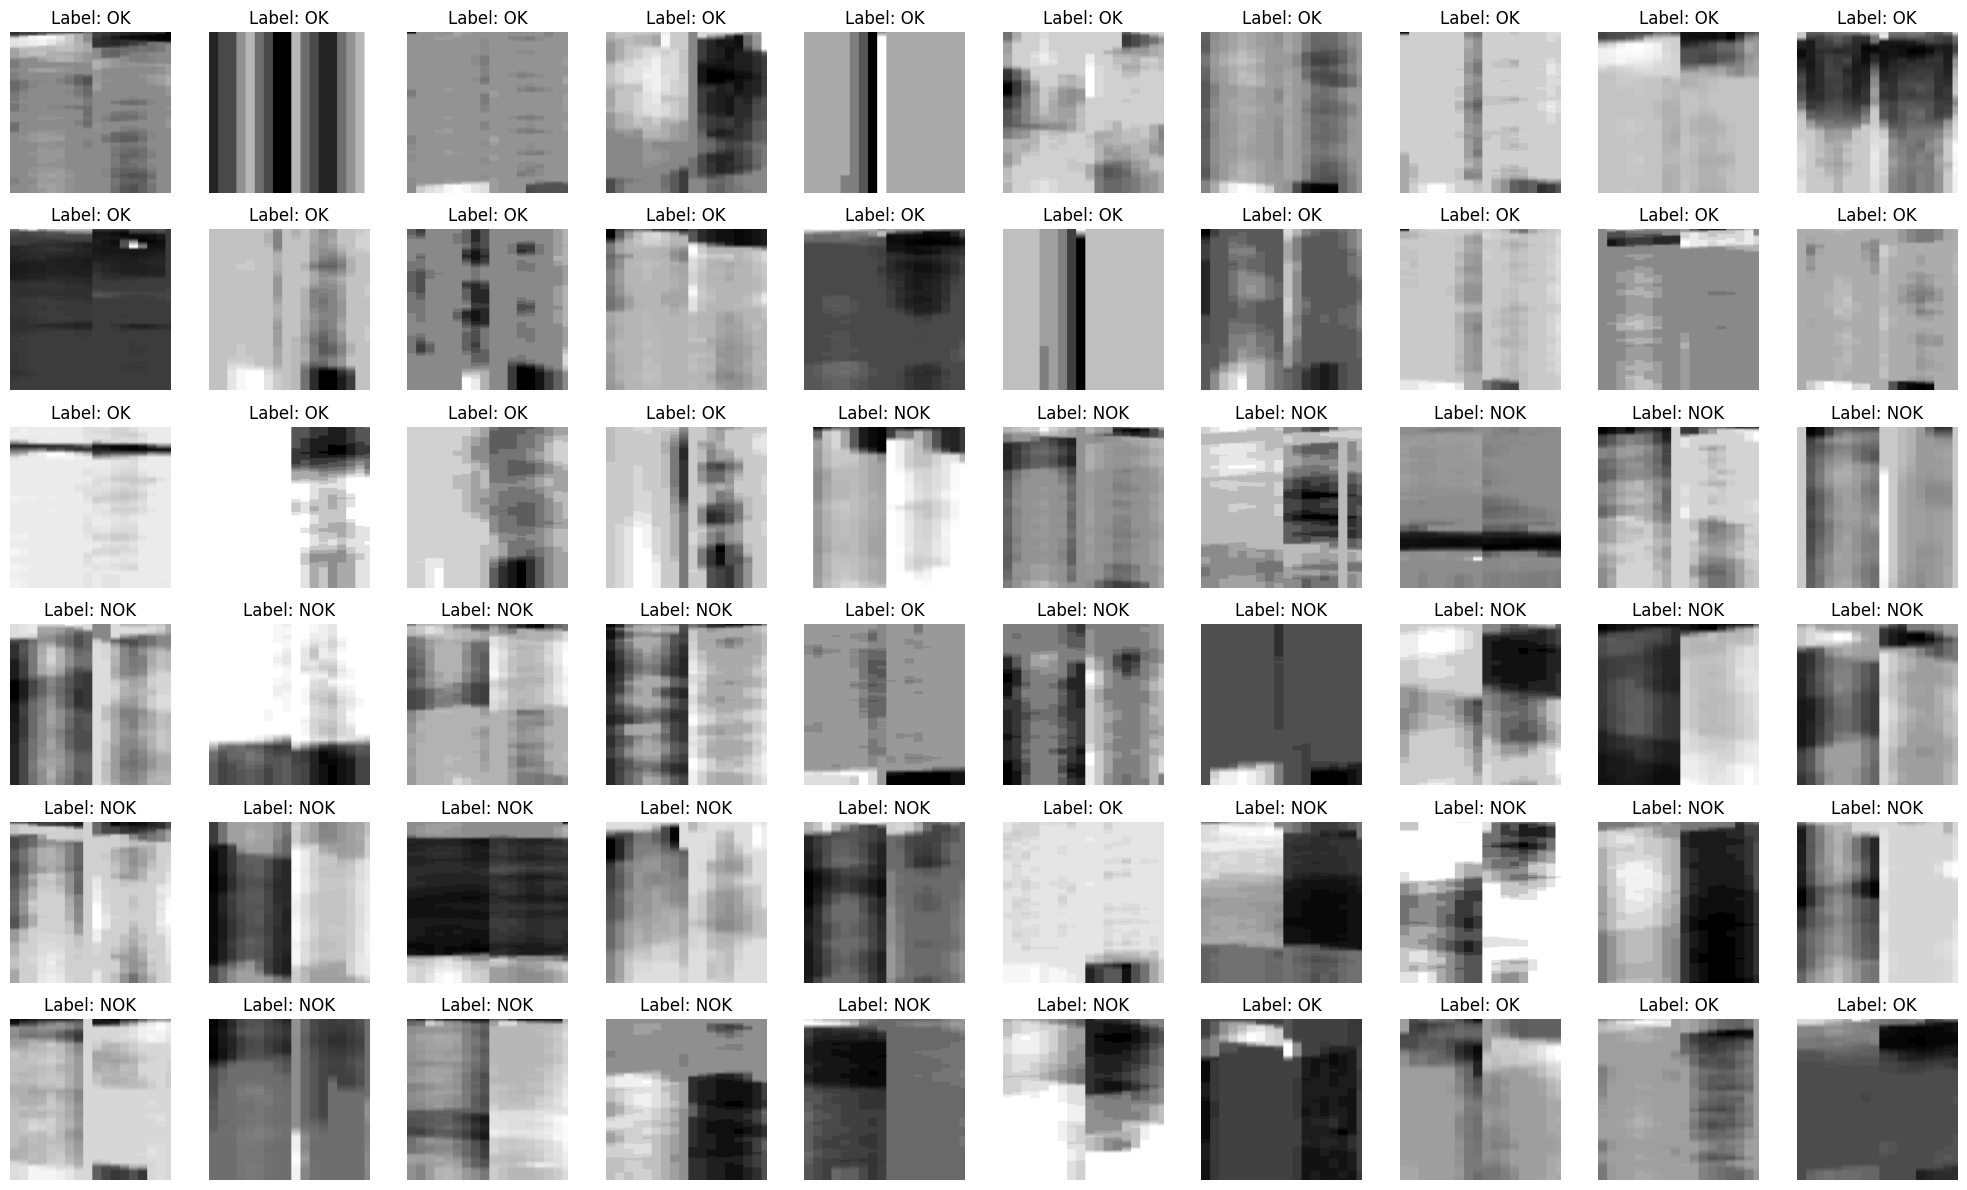

In [10]:
preprocessor.visualize_images_assess(features_dir_assess, labels_dir_assess)